In [1]:
import numpy as np
import torch
from diffusion import *
from torch.optim import Adam
import bgflow.distribution.sampling.mcmc as MCMC
import bgflow.distribution.energy.double_well as DoubleWell
import bgflow.distribution.normal as Normal
from diffusion.potential import LinearInterpolation 
from diffusion.utils import load_or_generate_and_then_save
import matplotlib.pyplot as plt

torch.random.manual_seed(199)

device = 'cuda'

In [2]:
# prepare a grid for plotting
ts = torch.linspace(0, 1, 50, dtype=torch.float32, device=device)
xs = torch.linspace(-3, 3, 50, dtype=torch.float32, device=device)

X, Y = torch.meshgrid(xs, ts, indexing='ij')


In [3]:
target = DoubleWell.DoubleWellEnergy(dim=1, b=-4., c=1.)
prior = Normal.NormalDistribution(dim=1)

def construct_net():
    return torch.nn.Sequential(torch.nn.Linear(2, 64), torch.nn.SiLU(), torch.nn.Linear(64, 1)).to(device)

In [4]:
# the potential function
def construct_potential():
    return LinearInterpolation(prior, target, construct_net())

In [5]:
naive_interpolation = lambda x, t :  (1-t) * target.energy(x) + (t) * prior.energy(x)

def to_normalized_probabilities(energies):
    probabilities = torch.exp(-energies)
    probabilities = probabilities - probabilities.min(dim=0, keepdim=True)[0]
    probabilities = probabilities / probabilities.sum(dim=0, keepdim=True)
    return probabilities

def compute_energies_naive(xs, ts):
    naive_out = naive_interpolation(xs, ts)
    return naive_out

def compute_probabilities_naive(xs, ts):
    naive_out = compute_energies_naive(xs, ts)
    return to_normalized_probabilities(naive_out.view(50,50))
 
def compute_forces_naive(xs, ts):
    xs_copy = xs.clone()
    xs_copy.requires_grad_(True)
    energies = compute_energies_naive(xs_copy, ts).sum()
    naive_forces = -torch.autograd.grad(energies, xs_copy)[0]
    return naive_forces

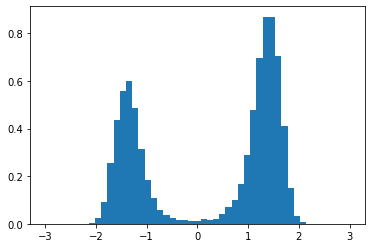

In [6]:
sampler = MCMC.GaussianMCMCSampler(energy=target, init_state=torch.tensor([0.]))


datafilepath = './data/double_well.npy'
data = torch.from_numpy(load_or_generate_and_then_save(datafilepath, lambda : sampler.sample(n_samples=50000)))

# plot histogram of the sampled data
counts, bins = np.histogram(data, bins=xs.cpu(), density=True)
# plt.plot(bins, torch.exp(-target.energy(torch.tensor(bins).unsqueeze_(1))))
plt.stairs(counts, bins, fill=True)
plt.show()


In [7]:
def cumulative_beta_linear(t, alpha=1.):
    '''The integral of the noise schedule over the interval [0, t]. In this case a simple linear schedule'''
    return alpha * t


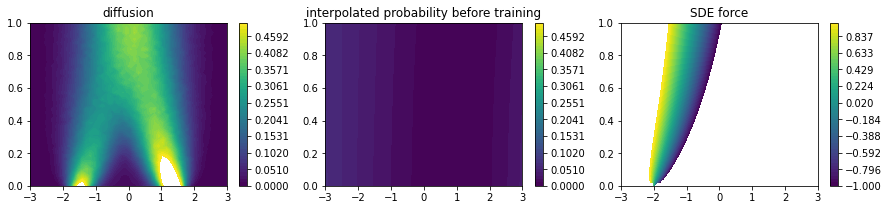

In [32]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))

sde = SDE(TransitionKernel(cumulative_beta=lambda t: cumulative_beta_linear(t)))
# Show diffusion distribution of the data when propagating using the SDE
z = torch.zeros_like(X)
for i, t in enumerate(ts):
    t_s=torch.full_like(data, t)
    x_t = sde.forward_sample(x_0=data, t=t_s)
    z[:, i] = torch.histogram(x_t, bins=torch.cat([xs.cpu(), torch.tensor([6.])]), density=True)[0]


model_probability = to_normalized_probabilities(construct_potential()(X.reshape(50*50, 1), Y.reshape(50*50, 1)).view(50,50).detach())

ax1.set_title('diffusion')
im1=ax1.contourf(X.cpu(), Y.cpu(), z.cpu(), levels=np.linspace(0, 0.5,50))
plt.colorbar(im1, ax=ax1)

ax2.set_title('interpolated probability before training')
im2=ax2.contourf(X.cpu(), Y.cpu(), model_probability.cpu(), levels=np.linspace(0,0.5,50))
plt.colorbar(im2, ax=ax2)

ax3.set_title('SDE force')
sde_forces = sde.force(torch.ones_like(X).reshape(50,50, 1) * -2, X.reshape(50,50, 1), Y.reshape(50,50,1))
im3 = ax3.contourf(X.cpu(), Y.cpu(), sde_forces.cpu().view(50,50), levels=np.linspace(-1,1,50))
plt.colorbar(im3, ax=ax3)

In [9]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)

def MSE_loss(prediction, ground_truth):
    loss = ((prediction - ground_truth)**2).mean()
    return loss

from diffusion.train import train


def make_trained_model(variance_schedule_multiplier, dt_regularization_factor, epochs=10):
    sde = SDE(TransitionKernel(cumulative_beta=lambda t: cumulative_beta_linear(t, variance_schedule_multiplier)))
    model = DiffusionModel(potential=construct_potential(), device=device, sde=sde)
    optimizer = Adam(model.parameters(), lr=1e-3)

    dt_loss = lambda dt : ((dt_regularization_factor * dt)**2).sum()

    train(model, 
        loss_fn_dx=MSE_loss,# torch.nn.functional.huber_loss, 
        loss_fn_dt=dt_loss,
        optimizer=optimizer, 
        data_loader=train_loader, 
        n_iterations=epochs,
        device=device)
    return model

In [10]:
# model1 = make_trained_model(1., 0., epochs=10)

In [11]:
## different ways of combining the strength of the variance decay (first parameter, higher means earlier mixing) and time regularization (second parameter, higher is stronger regularization.)
model_settings = [(1., 0.), (0.5, 0.), ( 2., 0.), (5., 0.), (0.5, 0.1), (2., 0.1), (5., 0.1)]
models = []
for (alpha, reg_factor) in model_settings:
      models.append(make_trained_model(variance_schedule_multiplier=alpha, dt_regularization_factor=reg_factor, epochs=20))

Epoch 0/20 total loss: 296.78033447265625418457
Epoch 1/20 total loss: 285.90777587890625673225
Epoch 2/20 total loss: 273.88333129882816804815
Epoch 3/20 total loss: 275.11126708984375587343
Epoch 4/20 total loss: 254.66340637207037250376
Epoch 5/20 total loss: 239.39474487304688314586
Epoch 6/20 total loss: 238.66731262207032750246
Epoch 7/20 total loss: 210.76623535156255333867
Epoch 8/20 total loss: 197.35667419433594768926
Epoch 9/20 total loss: 187.03599548339844888125
Epoch 10/20 total loss: 183.4085235595703381897
Epoch 11/20 total loss: 179.9670715332031267546
Epoch 12/20 total loss: 177.2342681884765630814
Epoch 13/20 total loss: 181.4017639160156230037
Epoch 14/20 total loss: 177.9028625488281221277
Epoch 15/20 total loss: 179.7232360839843841385
Epoch 16/20 total loss: 182.6870422363281253484
Epoch 17/20 total loss: 178.0149688720703690497
Epoch 18/20 total loss: 173.1669769287109492314
Epoch 19/20 total loss: 181.2519531257692260743
Epoch 0/20 total loss: 347.0204772949219

In [12]:
model1 = models[0]

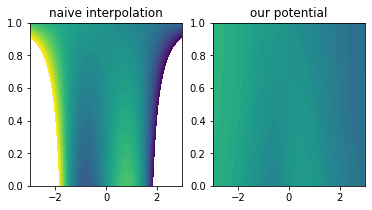

In [13]:
pre_training_out = model1(X.reshape(50*50, 1).clone(), Y.reshape(50*50, 1).clone())[0].view(50,50).detach()
#pre_training_out = to_normalized_probabilities(pre_training_out)

naive_forces = compute_forces_naive(X.reshape(50*50, 1), Y.reshape(50*50, 1)).view(50, 50)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))

ax1.set_title('naive interpolation')
ax1.contourf(X.cpu(), Y.cpu(), naive_forces.cpu(), levels=np.linspace(-10,10,50))
ax2.set_title('our potential')
ax2.contourf(X.cpu(), Y.cpu(), pre_training_out.cpu(), levels=np.linspace(-10,10,50))

plt.show()

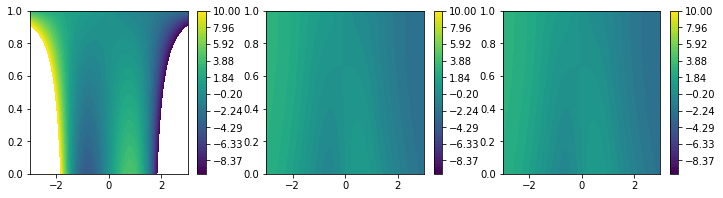

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3))

post_training_out = model1(X.reshape(50*50, 1), Y.reshape(50*50, 1))[0].view(50,50).detach()

im1 = ax1.contourf(X.cpu(), Y.cpu(), naive_forces.cpu(), levels=torch.linspace(-10,10, 50))
plt.colorbar(im1, ax=ax1)
im2 = ax2.contourf(X.cpu(), Y.cpu(), pre_training_out.cpu(), levels=torch.linspace(-10,10, 50))
plt.colorbar(im2, ax=ax2)
im3 = ax3.contourf(X.cpu(), Y.cpu(), post_training_out.cpu(), levels=torch.linspace(-10, 10, 50))
plt.colorbar(im3, ax=ax3)

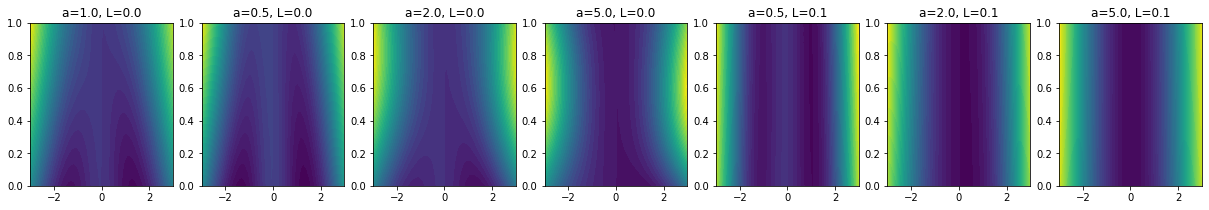

In [21]:
fig, axes = plt.subplots(1, len(models), figsize=(3 * len(models), 3))

for i, ((alpha, dt_reg), model) in enumerate(zip(model_settings, models)):
    post_training_energy = model.energy(X.reshape(50*50, 1), Y.reshape(50*50, 1)).view(50,50).detach()
    post_training_probability = to_normalized_probabilities(post_training_energy) 
    axes[i].contourf(X.cpu(), Y.cpu(), post_training_probability.cpu(),levels=50)# levels=torch.linspace(-10,10, 50))
    axes[i].set_title(f'a={alpha}, L={dt_reg}')

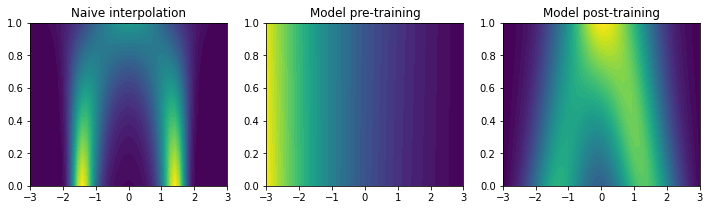

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

post_training_energy = model1.energy(X.reshape(50*50, 1), Y.reshape(50*50, 1)).view(50,50).detach()
post_training_probability = to_normalized_probabilities(post_training_energy) 

#post_training_probability = torch.exp(-post_training_energy)
#post_training_probability = post_training_energy
naive_probabilities = compute_probabilities_naive(X.reshape(50*50, 1), Y.reshape(50*50, 1)).view(50,50).cpu()

axes[0].set_title('Naive interpolation')
im1 = axes[0].contourf(X.cpu(), Y.cpu(), naive_probabilities, levels=50)# levels=torch.linspace(-10,10, 50))
plt.colorbar(im1, ax=ax1)
axes[1].set_title('Model pre-training')
im2 = axes[1].contourf(X.cpu(), Y.cpu(), model_probability.cpu(),levels=50)# levels=torch.linspace(-10,10, 50))
plt.colorbar(im2, ax=ax2)
axes[2].set_title('Model post-training')
im3 = axes[2].contourf(X.cpu(), Y.cpu(), post_training_probability.cpu(),levels=50)# levels=torch.linspace(-10,10, 50))b
plt.colorbar(im3, ax=ax3)

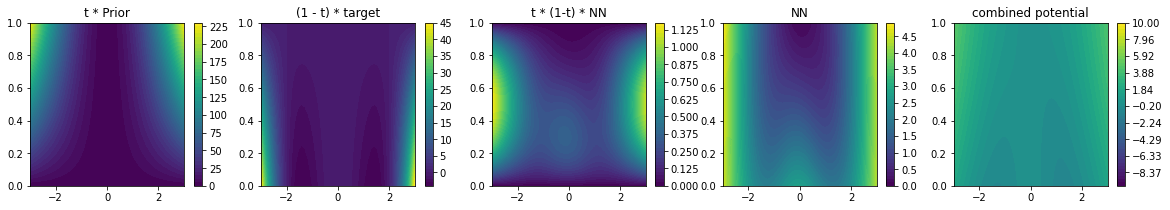

In [17]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 3))

t_s = Y.reshape(50*50, 1)
ax1.set_title('t * Prior')
im1 = ax1.contourf(X.cpu(), Y.cpu(), Y.cpu() * prior.energy(X).cpu(), levels=50)# levels=torch.linspace(-10,10, 50))
plt.colorbar(im1, ax=ax1)

ax2.set_title('(1 - t) * target')
im2 = ax2.contourf(X.cpu(), Y.cpu(), (1-Y).cpu() * target.energy(X.reshape(50, 50, 1)).squeeze_().cpu(), levels=50)# levels=torch.linspace(-10,10, 50))
plt.colorbar(im2, ax=ax2)

ax3.set_title('t * (1-t) * NN')
im3 = ax3.contourf(X.cpu(), Y.cpu(), (Y * (1-Y) * model1.potential.net(torch.hstack([X.reshape(50*50, 1), t_s])).view(50,50).detach()).cpu(),levels=50)# levels=torch.linspace(-10,10, 50))
plt.colorbar(im3, ax=ax3)

ax4.set_title('NN')
# ax4.contourf(X.cpu(), Y.cpu(), (Y * (1-Y)).cpu())
im4 = ax4.contourf(X.cpu(), Y.cpu(), model1.potential.net(torch.hstack([X.reshape(50*50, 1), t_s])).view(50,50).detach().cpu(),levels=50)# levels=torch.linspace(-10,10, 50))
plt.colorbar(im4, ax=ax4)

ax5.set_title('combined potential')
im5 = ax5.contourf(X.cpu(), Y.cpu(), model1.energy(X.reshape(50*50, 1), t_s).view(50,50).detach().cpu(), levels=torch.linspace(-10,10, 50))
plt.colorbar(im5, ax=ax5)

(-10.0, 20.0)

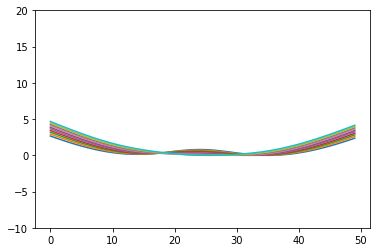

In [18]:
#post_training_energy = V(X.reshape(50*50, 1), Y.reshape(50*50, 1)).view(50,50).detach()

# for t in [0, 10, 20, 40, -1]:
#     t_s = torch.full_like(xs, ts[t])
#     plt.plot(compute_forces_naive(xs.unsqueeze(1), t_s.unsqueeze(1)).cpu())
# plt.ylim(-10,20)

for t in np.arange(0, 50, 5):
    t_s = torch.full_like(xs, ts[t])
    u = model1.energy(xs.unsqueeze(1), t_s.unsqueeze(1)).detach().cpu()
    plt.plot(u - u.min())
plt.ylim(-10,20)

In [19]:
from math import sqrt

def return_without_graph(fn, *args):
    out = fn(*args)
    return out.detach()

def langevin(force: callable, x_0: torch.tensor, tau: torch.FloatType):
    '''Do langevin dynamics of the potential from x_0 at t=1 to x_t at t=0 with timestep tau.
    (actually, start at t=1e-5 for stability reasons)'''
    t = 1
    x_t = x_0
    sqrt_tau = sqrt(tau)
    t_s = torch.full_like(x_t, t)
    while t > 1e-5:
        # x_t = x_t + tau * 0.5 * force.energy(x_t) + sqrt_tau * torch.rand_like(x_t)
        x_t = x_t + tau * 0.5 * return_without_graph(force, x_t.clone(), t_s.clone()) + sqrt_tau * torch.randn_like(x_t)
        t_s = t_s - tau
        t -= tau
    return x_t


x_0 = torch.randn((10000, 1)).to(device)
x_t = langevin(lambda x, t: model1(x, t)[0], x_0, 0.001)

#x_t = langevin(lambda x, t: compute_forces_naive(x, t), x_0, 0.001)

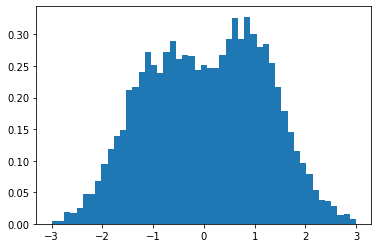

In [20]:
# plot histogram of the sampled data
counts, bins = np.histogram(x_t.detach().cpu(), bins=xs.cpu(), density=True)
# plt.plot(bins, torch.exp(-target.energy(torch.tensor(bins).unsqueeze_(1))))
plt.stairs(counts, bins, fill=True)
plt.show()
